# Exploration.16 - 다음에 볼 영화 예측하기 (추천하기)

- 현재 데이터는 User별 본 영화에 대한 평점 데이터를 가지고 있음 (Movielens 1M Dataset)
- Session based Recommendation 시스템을 제작하고자 하여 UserID를 SeesionID로 가정하고 본 exploration을 진행할 예정

## import Package

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [3]:
len(data)

1000209

- 총 1,000,209 개의 데이터가 존재함
- 데이터의 feature는 'UserId', 'ItemId', 'Rating', 'Time'로 총 4개가 있음

In [4]:
data['UserId'].nunique()

6040

- 총 6,040 명의 사용자들의 데이터가 있음

In [5]:
data['ItemId'].nunique()

3706

- 총 3,706 편의 영화 데이터가 있음

## Preprocessing

### 1. 결측치 확인

In [6]:
data.isnull().sum()

UserId    0
ItemId    0
Rating    0
Time      0
dtype: int64

- 현재 기준으로는 결측치는 없다고 판단됨

### 2. 날짜 변환
- 현재 날짜는 보기 어렵게 되어있음
- pd.to_datetime()을 이용하여 보기 편하게 시간을 표현하려고 함

In [7]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head(10)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


- pandas 날짜 변환 : https://blog.doosikbae.com/89

- 'Time' column에서의 시간이 초단위로 바뀌기 때문에 해당 시간은 영화를 본 시간으로 판단되지 않음
- 검색 해본 결과 Time에서의 시간은 User가 Rating을 작성한 시간임을 알아냄  
https://blog.naver.com/PostView.naver?blogId=mini_s0n&logNo=222409833212&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView

In [8]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

- 데이터는 2000년 4월 25일부터 2003년 2월 28일까지 약 2년 10개월간의 기간을 가지고 있음

### 3. Rating 가공

In [9]:
data['Rating'].max(), data['Rating'].min()

(5, 1)

- 'Rating'에서의 평점은 최대 5점, 최소 1점을 가짐

In [10]:
data[data['ItemId'] == 2340].head()

,UserId,ItemId,Rating,Time
24,1,2340,3,2000-12-31 22:01:43
3594,26,2340,4,2000-12-30 01:52:58
5477,38,2340,3,2000-12-28 23:07:15
6337,45,2340,2,2000-12-28 07:33:46
14179,116,2340,4,2001-08-10 12:55:50


- 영화별로 Rating이 다름
- Rating은 영화에 대한 전체 이용자들의 평점이 아닌 개개인(UserId)이 준 평점으로 판단함

In [11]:
rating_rate = data.groupby('Rating')['UserId'].count()
rating_rate

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: UserId, dtype: int64

<AxesSubplot:xlabel='Rating', ylabel='count'>

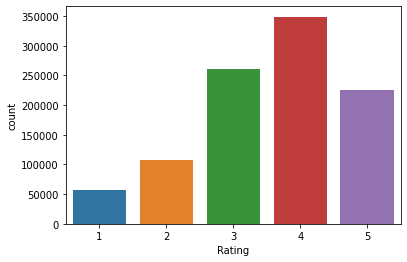

In [12]:
sns.countplot(data=data, x='Rating')

In [13]:
for i in range(1,6):
    print('평점 {}점의 비율 : {:.2f}'.format(i, len(data[data['Rating'] == i]) / len(data)))

평점 1점의 비율 : 0.06
평점 2점의 비율 : 0.11
평점 3점의 비율 : 0.26
평점 4점의 비율 : 0.35
평점 5점의 비율 : 0.23


- 각 유저 별 각 영화에 대한 데이터가 하나씩밖에 없음
- **강제로 세션으로 가정하고 본 문제를 풀기에는 무리가 있음**
    - 세션 데이터에서는 데이터 중복 여부가 크게 작용할 것 같다고 판단됨
    - 예를 들어 1번 유저가 a라는 영화 페이지를 1번 본 것과 5번 본 것은 크게 차이가 남
    - 하지만 본 데이터에서는 중복이 없기 때문에 세션을 가정하고 문제를 풀어가기 어려울 것으로 판단됨
    - Rating을 가공하여 세션 문제에 맞게 데이터를 변형시키고자 함
        - v.1.03에서는 Rating을 영화 페이지 세션 기록으로 보고 가공하려고 했음
        - 시간적 문제로 v.1.03에서 가공하다가 가공에 필요한 시간이 너무 길어 제출기한을 못 지킬 것 같다는 판단을 함
        - 데이터 자체를 다운 샘플링하여 진행할 예정

- 내가 생각한 Rating 가공 방안
    - Rating 수 만큼 같은 행을 늘릴 예정 (똑같은 행을 Rating만큼 늘릴 예정)
    - Rating 3과 4의 비율이 다른 평점보다 높아 모델 성능이 좋게 나올지 의문이 생김
    - Rating 수만큼 전체 데이터수가 매우 많아질 것을 우려하여 전체 데이터 중에 일부만 사용할 예정
    - **이중 for문을 활용하여 해당 데이터를 가공하고자 하였지만 시간이 너무 오래 걸림**
    - **기본 데이터셋을 활용하여 본 exploration을 사용하고자 함**
   https://github.com/TaeWonKang95/Aiffel_Exploration/blob/66795951897100b53baf8eeaff3df13577c2862f/Exploration.16_SBR_Recommendation_Movie/%5BE-16%5Ddataset_transform.ipynb

In [14]:
data.head(20)

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
36,1,1836,5,2000-12-31 22:02:52
3,1,3408,4,2000-12-31 22:04:35
7,1,2804,5,2000-12-31 22:11:59
47,1,1207,4,2000-12-31 22:11:59
0,1,1193,5,2000-12-31 22:12:40


#### 3-1. Rating 3점 미만 데이터 제외하기

- 3점 미만은 중요도에서 떨어지는 것으로 판단하여 제외할 예정

In [15]:
data_orgin = data

- 평점 3점 미만인 데이터(원본 데이터)도 가진 data_orgin을 만듦

In [16]:
data = data[data['Rating'] >= 3]
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [17]:
data[data['Rating'] < 3]

,UserId,ItemId,Rating,Time


- 3점 미만의 데이터는 모두 제거됨

In [18]:
len(data)

836478

### 4. UserId 파악

In [19]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [20]:
userid_length.median(), userid_length.mean()

(81.0, 138.51266766020865)

- 각 userid에 따른 데이터 갯수 중간값 : 81개
- 각 uesrid에 따른 데이터 갯수 평균값 : 약 138.5개

In [21]:
userid_length.min(), userid_length.max()

(1, 1968)

- 각각의 uesrid에서 가장 작은 데이터를 가진 userid는 1개의 데이터를 가짐
    - session으로 가정하였기 때문에 session이 1인 데이터는 큰 의미가 없다고 판단됨
    - userid_length가 1인 데이터는 삭제해야함
- 각각의 userid에서 가장 큰 데이터를 가진 userid는 1,968개의 데이터를 가짐
    - userid 분포를 파악한 후에 적당한 사이즈로 잘라줄 예정

In [22]:
userid_length.quantile(0.99)

734.6199999999999

In [23]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()   # cumsum : 누적합
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99]

length_percent_cumsum_99

1      0.000166
7      0.000331
9      0.000994
10     0.001159
11     0.001987
         ...   
725    0.989237
726    0.989402
728    0.989568
731    0.989733
734    0.989899
Length: 584, dtype: float64

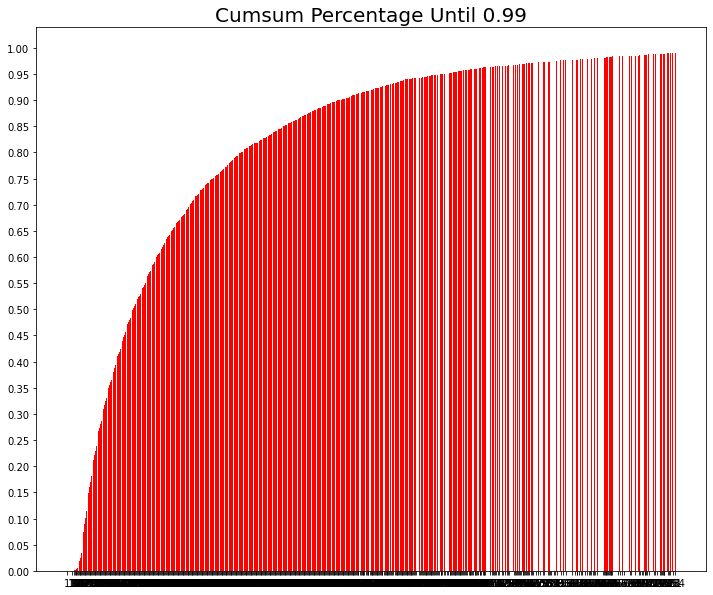

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_99.index,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

### 5. 필요없는 데이터 제거

In [25]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [26]:
data = cleanse_recursive(data, shortest=5, least_click=20)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


- 기존 : 1,000,209 개의 데이터
- Rating 3미만 제거 후 : 836,478 개의 데이터
- 필요없는 데이터 제거 후 : 829,842 개의 데이터

- userid당 5개 이하의 데이터는 삭제함
- 20번 이하로 체크된 영화 데이터 삭제함

## 시간 순으로 정렬하기

In [27]:
data = data.sort_values('Time')
data.head(20)

,UserId,ItemId,Rating,Time
1000138,6040,858,4,2000-04-25 23:05:32
1000153,6040,2384,4,2000-04-25 23:05:54
999873,6040,593,5,2000-04-25 23:05:54
1000192,6040,2019,5,2000-04-25 23:06:17
1000007,6040,1961,4,2000-04-25 23:06:17
999877,6040,1419,3,2000-04-25 23:07:36
999920,6040,213,5,2000-04-25 23:07:36
999980,6040,3505,4,2000-04-25 23:07:36
999967,6040,3111,5,2000-04-25 23:07:36
999884,6040,912,5,2000-04-25 23:09:51


## Train, val, test 셋 나누기

### 1. 날짜를 기준으로 Train, val, test 분리

In [28]:
data[data['UserId'] == 36].head(), data[data['UserId'] == 36].tail()

(      UserId  ItemId  Rating                Time
 5130      36    2671       5 2000-12-29 03:35:55
 5163      36    2250       4 2000-12-29 03:35:55
 5313      36    2023       4 2000-12-29 03:35:55
 5088      36    1270       5 2000-12-29 03:36:22
 5351      36    1097       4 2000-12-29 03:36:47,
       UserId  ItemId  Rating                Time
 5104      36     247       4 2002-12-22 08:17:48
 5062      36    1266       5 2002-12-22 08:18:29
 5076      36     595       4 2002-12-22 08:18:29
 5126      36    1295       4 2002-12-22 08:18:29
 5180      36    3639       4 2002-12-22 08:18:45)

- 해당 데이터의 UserId는 세션 데이터가 아님
- 세션은 같은 유저라도 시간에 따라 다른 세션이 지정됨
- 해당 데이터는 같은 유저면 시간이 달라도 같은 UserId로 저장됨
- 세션을 염두해서 해당 문제를 해결하려면 시간만을 기준으로 둬야한다고 판단함

In [29]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    
    return before_date, after_date

In [30]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

- 약 3년간의 데이터이므로 뒤에서부터 180일(약 3달)을 test로 지정함
- train셋 중에 뒤에서부터 180일(약 3달)을 val로 지정함

In [31]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 813024
	 Sessions: 6036
	 Items: 2805
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:14:13

* valid Set Stats Info
	 Events: 9623
	 Sessions: 388
	 Items: 2230
	 First Time : 2002-03-05 04:24:20
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 7195
	 Sessions: 331
	 Items: 1972
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



### 2. train에 없는 아이템 제거 

In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- get
    - Key로 Value얻기
    - 해당 키에 대한 값이 없으면 두번째 인자가 디폴트값으로 저장됨  
https://wikidocs.net/16

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline

### 1. SessionDataset

In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
1000153,6040,2384,4,2000-04-25 23:05:54,1
999873,6040,593,5,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999920,6040,213,5,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999884,6040,912,5,2000-04-25 23:09:51,9


In [37]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 812633, 812752, 813024], dtype=int32)

In [38]:
tr_dataset.df[tr_dataset.df['item_idx'] == 53].head()

,UserId,ItemId,Rating,Time,item_idx
999794,6039,282,4,2000-04-25 23:25:58,53
998409,6035,282,4,2000-04-26 01:23:34,53
998832,6036,282,3,2000-04-26 13:00:04,53
993153,6000,282,3,2000-04-28 00:47:50,53
996092,6016,282,3,2000-04-28 22:03:49,53


In [39]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6033, 6034, 6035])

- click_offsets : 각 세션이 시작된 인덱스를 담고 있음
- session_idx : 각 세션을 인덱싱한 np.array

### 2. SessionDataLoader
- SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스
- \_\_iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield함
- mask는 후에 RNN Cell State를 초기화하는데 사용

In [40]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [41]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(20)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,2000-04-25 23:05:32,0
1000153,6040,2384,4,2000-04-25 23:05:54,1
999873,6040,593,5,2000-04-25 23:05:54,2
1000192,6040,2019,5,2000-04-25 23:06:17,3
1000007,6040,1961,4,2000-04-25 23:06:17,4
999877,6040,1419,3,2000-04-25 23:07:36,5
999920,6040,213,5,2000-04-25 23:07:36,6
999980,6040,3505,4,2000-04-25 23:07:36,7
999967,6040,3111,5,2000-04-25 23:07:36,8
999884,6040,912,5,2000-04-25 23:09:51,9


In [42]:
iter_ex = iter(tr_data_loader)

In [43]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53  94 192]
Label Item Idx are :       [  1  54 164 193]
Previous Masked Input Idx are []


- Model Input Item Idx : SessionId 별 첫번째 item_idx 번호 (배치사이즈만큼)
- Label Item Idx : Model Input Item Idx의 item_idx 다음 번호

## Modeling

### 1. Evaluation Metric (MRR)

- MRR (Mean Reciprocal Rank)
    - MRR은 사용자가 몇 개의 컨텐츠에 관심이 있었는지, 각 관련 컨텐츠는 어느 위치에 있었는지를 고려하지 않음
    - 오직, 가장 상위의 관련 컨텐츠의 위치만을 고려하여 점수를 계산함으로써 가장 관련있는 컨텐츠가 얼마나 상위에 올라가 있는지를 평가
    
    - MRR의 장점
        - 간단하고 쉬움
        - 제공된 목록 중 가장 상위의 관련된 컨텐츠에만 집중하기 때문에, 사용자에 가장 관련있는 컨텐츠가 최상위에 있는가를 평가할 때 용이
        - 새로운 컨텐츠가 아니라 이미 사용자가 알고 있는 컨텐츠 중 가장 선호할만한 컨텐츠를 보여주고자 할 때 좋은 평가 기준이 됨
    - MRR의 단점
        - 제공된 목록 중 하나의 컨텐츠에만 집중하기 때문에 나머지 부분에 대해서는 평가하지 않음  
        (2, 3번째 관련 컨텐츠에 대해서는 평가를 하지 않음)
        - 관련 컨텐츠의 개수가 달라도 첫 번째 관련 컨텐츠의 위치가 같은 경우 같은 점수를 가지므로 변별력을 가지기 어려움
        - 사용자가 컨텐츠에 대해 잘 알지 못해 여러 번 탐색을 해야 하는 경우 살펴봐야 하는(관련있는) 컨텐츠의 개수가 1개 이상일 가능성이 높으므로 좋은 평가 기준이 되기 어려움

- MRR : https://lamttic.github.io/2020/03/20/01.html

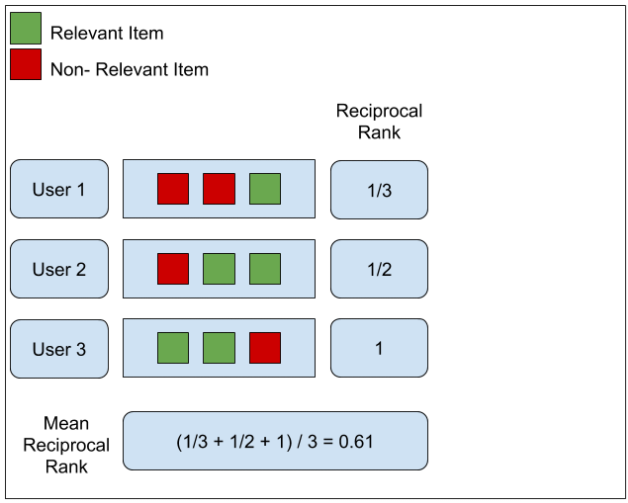

In [44]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 2. Model Architecture

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [46]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [47]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [48]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 2805)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    428550    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 2805)               143055    
Total params: 571,605
Trainable params: 571,605
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [49]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    
    history = {'val_recall':[], 'val_mrr':[], 'train_loss':[], 'Epoch':[]} # 시각화를 위한 history를 생성함
    
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        
        history['val_recall'].append(float(val_recall))
        history['val_mrr'].append(float(val_mrr))
        history['train_loss'].append(result[0])
        history['Epoch'].append(epoch)

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
    return history


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [50]:
training = train_model(model, args)

Evaluation:  14%|█▍        | 5/36 [00:05<00:36,  1.19s/it]


	 - Recall@20 epoch 1: 0.055469
	 - MRR@20    epoch 1: 0.012532



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 2: 0.066406
	 - MRR@20    epoch 2: 0.017654



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.10s/it]

	 - Recall@20 epoch 3: 0.077344
	 - MRR@20    epoch 3: 0.019575



In [51]:
training

{'val_recall': [0.05546875, 0.06640625, 0.07734375],
 'val_mrr': [0.012531939071098319, 0.017653999119296382, 0.019574632339785687],
 'train_loss': [7.084926605224609, 6.791426181793213, 6.668675899505615],
 'Epoch': [1, 2, 3]}

In [52]:
def draw_graph(training):
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 1, 1)
    sns.lineplot(x=training['Epoch'], y=training['train_loss'], label='train_loss')

    plt.subplot(3, 1, 2)
    sns.lineplot(x=training['Epoch'], y=training['val_recall'], label='val_recall')

    plt.subplot(3, 1, 3)
    sns.lineplot(x=training['Epoch'], y=training['val_mrr'], label='val_mrr')

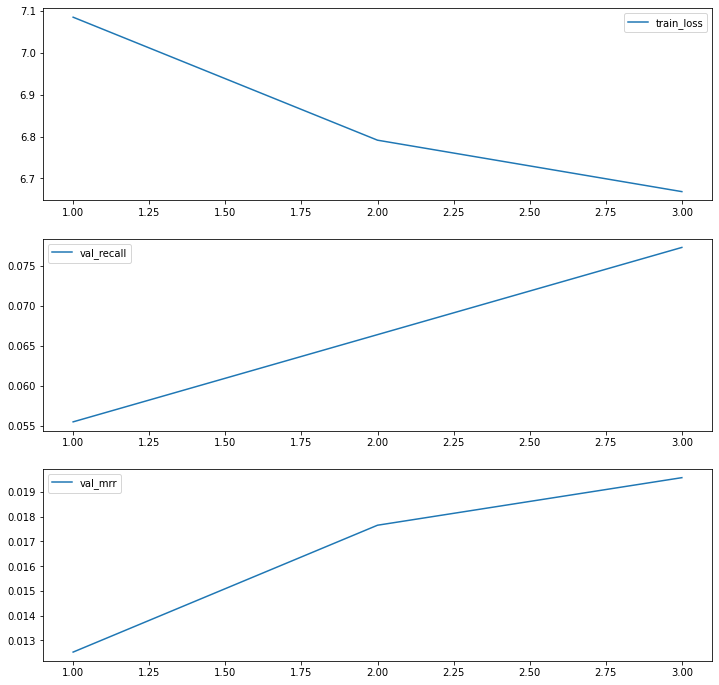

In [53]:
draw_graph(training)

- train의 accuracy 자체가 매우 낮은것으로 판단됨
    - epoch=3일 때, 마지막 accuracy=0.0156
- train loss는 조금씩 줄어드는 것으로 보임
- recall과 mrr은 개선되지 않음
- epoch 3번으로는 모델 성능을 보기 어려움

## 모델 개선 1 - epoch 횟수 증가

In [54]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [55]:
model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 2805)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    428550    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 2805)               143055    
Total params: 571,605
Trainable params: 571,605
Non-trainable params: 0
_________________________________________________________________


- epoch을 기존 3번에서 10번으로 증가시켜봄

In [56]:
training1 = train_model(model1, args1)

Evaluation:  14%|█▍        | 5/36 [00:05<00:36,  1.18s/it]


	 - Recall@20 epoch 1: 0.057813
	 - MRR@20    epoch 1: 0.012690



Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.14s/it]


	 - Recall@20 epoch 2: 0.067187
	 - MRR@20    epoch 2: 0.018490



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.12s/it]


	 - Recall@20 epoch 3: 0.083594
	 - MRR@20    epoch 3: 0.019151



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.12s/it]


	 - Recall@20 epoch 4: 0.085156
	 - MRR@20    epoch 4: 0.021621



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 5: 0.089844
	 - MRR@20    epoch 5: 0.023364



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 6: 0.096094
	 - MRR@20    epoch 6: 0.024979



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 7: 0.098437
	 - MRR@20    epoch 7: 0.024177



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 8: 0.096875
	 - MRR@20    epoch 8: 0.024629



Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.13s/it]


	 - Recall@20 epoch 9: 0.096094
	 - MRR@20    epoch 9: 0.023542



Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.13s/it]

	 - Recall@20 epoch 10: 0.093750
	 - MRR@20    epoch 10: 0.022886



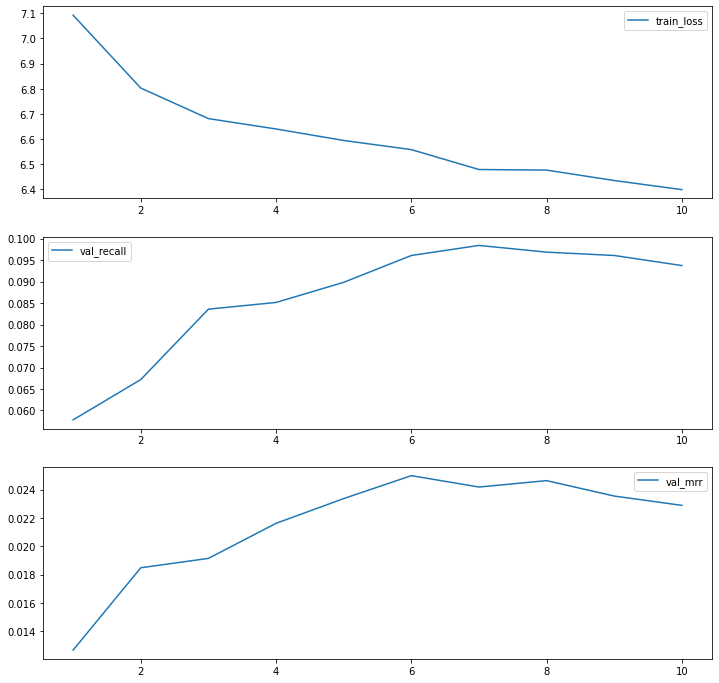

In [58]:
draw_graph(training1)

- train loss가 점차 줄어듦
- recall과 mrr은 조금씩 개선되어감

## 모델 개선 2 - hidden state 조정

- hidden state를 기존 50에서 100으로 증가

In [59]:
arg2 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [60]:
model2 = create_model(arg2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 2805)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  872100    
_________________________________________________________________
dropout_2 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_2 (Dense)              (256, 2805)               283305    
Total params: 1,155,405
Trainable params: 1,155,405
Non-trainable params: 0
_________________________________________________________________


In [61]:
training2 = train_model(model2, arg2)

Evaluation:  14%|█▍        | 5/36 [00:05<00:37,  1.20s/it]


	 - Recall@20 epoch 1: 0.060937
	 - MRR@20    epoch 1: 0.014598



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 2: 0.073438
	 - MRR@20    epoch 2: 0.019984



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.10s/it]


	 - Recall@20 epoch 3: 0.082812
	 - MRR@20    epoch 3: 0.020218



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 4: 0.091406
	 - MRR@20    epoch 4: 0.021306



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 5: 0.093750
	 - MRR@20    epoch 5: 0.024089



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 6: 0.092969
	 - MRR@20    epoch 6: 0.023391



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.09s/it]


	 - Recall@20 epoch 7: 0.100000
	 - MRR@20    epoch 7: 0.026609



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.10s/it]


	 - Recall@20 epoch 8: 0.101562
	 - MRR@20    epoch 8: 0.025426



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.09s/it]


	 - Recall@20 epoch 9: 0.104688
	 - MRR@20    epoch 9: 0.024568



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]

	 - Recall@20 epoch 10: 0.102344
	 - MRR@20    epoch 10: 0.022786



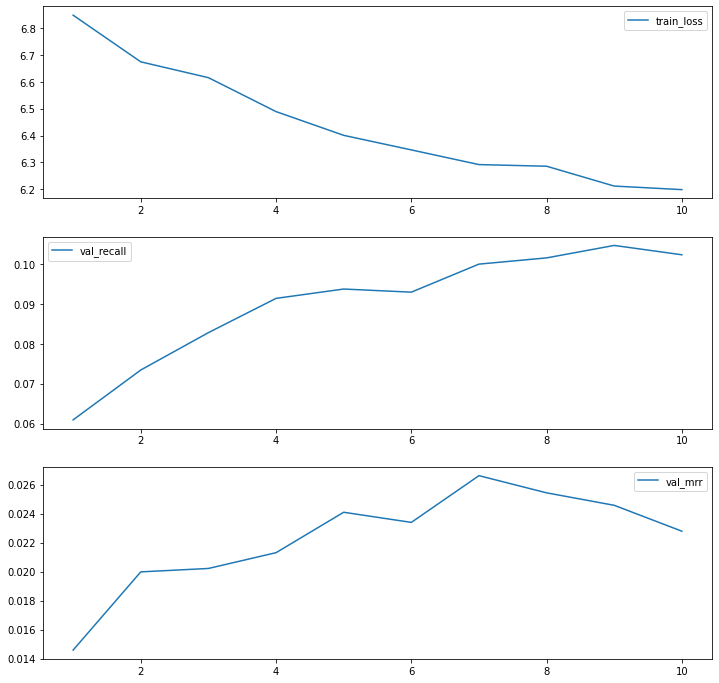

In [62]:
draw_graph(training2)

- train loss는 점차 떨어짐
- recall은 점차 개선되어감
- mrr은 성능이 개선되어 가다가 조금씩 성능이 떨어짐
- hidden state를 늘리기 전보다 약간씩 성능이 향상됨  
(하지만 너무 미세하게 향상됨)

## 모델 개선 3 - hidden state 조정

- hidden state를 기존 50에서 100 -> 256으로 증가시킴

In [63]:
arg3 = Args(tr, val, test, batch_size=256, hsz=256, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [64]:
model3 = create_model(arg3)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 2805)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 256), (256, 256)]  2352384   
_________________________________________________________________
dropout_3 (Dropout)          (256, 256)                0         
_________________________________________________________________
dense_3 (Dense)              (256, 2805)               720885    
Total params: 3,073,269
Trainable params: 3,073,269
Non-trainable params: 0
_________________________________________________________________


In [65]:
training3 = train_model(model3, arg3)

Evaluation:  14%|█▍        | 5/36 [00:05<00:35,  1.15s/it]


	 - Recall@20 epoch 1: 0.072656
	 - MRR@20    epoch 1: 0.018003



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.12s/it]


	 - Recall@20 epoch 2: 0.080469
	 - MRR@20    epoch 2: 0.022272



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.09s/it]


	 - Recall@20 epoch 3: 0.087500
	 - MRR@20    epoch 3: 0.023251



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]


	 - Recall@20 epoch 4: 0.087500
	 - MRR@20    epoch 4: 0.023986



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 5: 0.091406
	 - MRR@20    epoch 5: 0.023174



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.13s/it]


	 - Recall@20 epoch 6: 0.090625
	 - MRR@20    epoch 6: 0.023117



Evaluation:  14%|█▍        | 5/36 [00:05<00:33,  1.08s/it]


	 - Recall@20 epoch 7: 0.094531
	 - MRR@20    epoch 7: 0.023810



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]


	 - Recall@20 epoch 8: 0.096094
	 - MRR@20    epoch 8: 0.025338



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.11s/it]


	 - Recall@20 epoch 9: 0.092969
	 - MRR@20    epoch 9: 0.023358



Evaluation:  14%|█▍        | 5/36 [00:05<00:34,  1.10s/it]

	 - Recall@20 epoch 10: 0.087500
	 - MRR@20    epoch 10: 0.022516



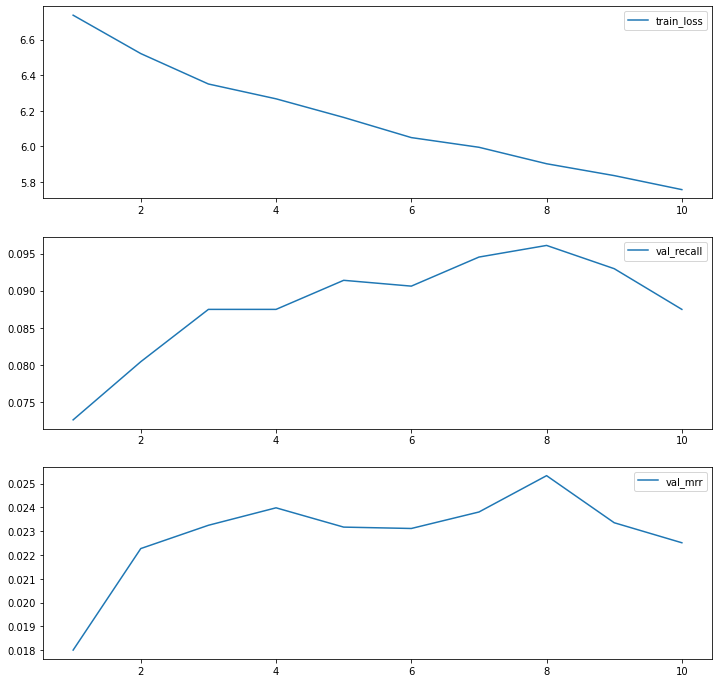

In [66]:
draw_graph(training3)

- accuracy는 조금 더 향상됨
    - hidden state가 100 일 때, 최대 accuracy 0.0469
    - hidden state가 256 일 때, 최대 accuracy 0.0508
- recall과 mrr은 성능이 향상되다가 조금씩 떨어짐

## 모델 개선 4 - k 조정

- 추천 아이템 갯수인 k를 기존 20에서 30으로 늘림

In [67]:
arg4 = Args(tr, val, test, batch_size=256, hsz=256, drop_rate=0.1, lr=0.001, epochs=10, k=30)

In [68]:
model4 = create_model(arg4)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(256, 1, 2805)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 256), (256, 256)]  2352384   
_________________________________________________________________
dropout_4 (Dropout)          (256, 256)                0         
_________________________________________________________________
dense_4 (Dense)              (256, 2805)               720885    
Total params: 3,073,269
Trainable params: 3,073,269
Non-trainable params: 0
_________________________________________________________________


In [69]:
training4 = train_model(model4, arg4)

Evaluation:  14%|█▍        | 5/36 [00:07<00:49,  1.60s/it]


	 - Recall@30 epoch 1: 0.088281
	 - MRR@30    epoch 1: 0.019060



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.55s/it]


	 - Recall@30 epoch 2: 0.109375
	 - MRR@30    epoch 2: 0.025115



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.54s/it]


	 - Recall@30 epoch 3: 0.110937
	 - MRR@30    epoch 3: 0.026123



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.54s/it]


	 - Recall@30 epoch 4: 0.109375
	 - MRR@30    epoch 4: 0.025254



Evaluation:  14%|█▍        | 5/36 [00:07<00:48,  1.56s/it]


	 - Recall@30 epoch 5: 0.106250
	 - MRR@30    epoch 5: 0.023389



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.52s/it]


	 - Recall@30 epoch 6: 0.110156
	 - MRR@30    epoch 6: 0.022085



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.53s/it]


	 - Recall@30 epoch 7: 0.108594
	 - MRR@30    epoch 7: 0.022309



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.53s/it]


	 - Recall@30 epoch 8: 0.108594
	 - MRR@30    epoch 8: 0.024082



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.53s/it]


	 - Recall@30 epoch 9: 0.105469
	 - MRR@30    epoch 9: 0.023907



Evaluation:  14%|█▍        | 5/36 [00:07<00:47,  1.54s/it]

	 - Recall@30 epoch 10: 0.100781
	 - MRR@30    epoch 10: 0.024134



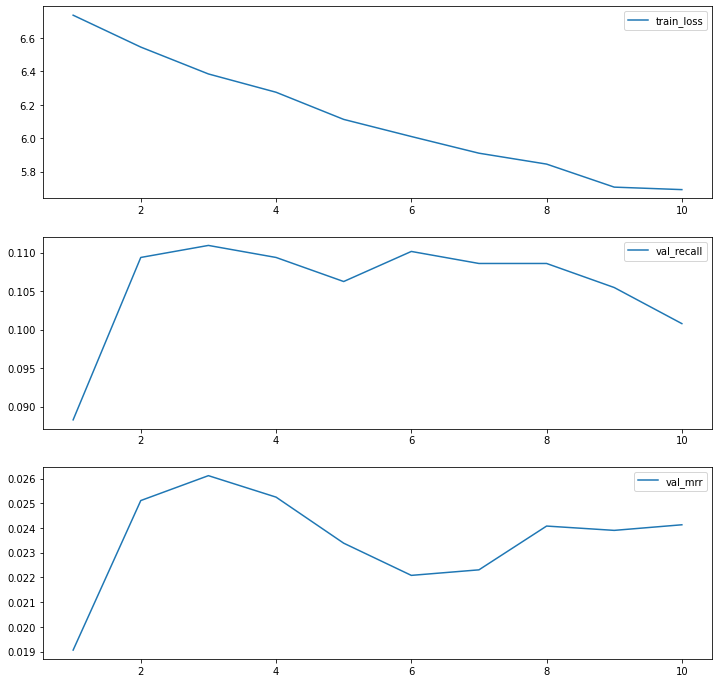

In [70]:
draw_graph(training4)

- k를 늘렸을 때는 성능이 대체로 떨어짐

## 모델 학습 결론

- 모델3이 가장 좋은 성능을 보임
    - batch_size : 256
    - hidden state : 256
    - drop_rate=0.1
    - lr=0.001
    - epochs=10
    - k=20
- Session Based Recommendation으로 해당 exploration을 풀어가기에는 문제가 많음
    - 해당 exploration은 세션 데이터가 아님
    - 억지로 세션 데이터처럼 간주하고 문제를 해결하기에는 성능 개선의 어려움을 크게 느낌
- 성능의 개선이 확연하게 좋아지진 않지만 epoch이 진행됨에 따라 조금씩 향상됨은 알 수 있었음

## 모델 평가

In [72]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model3, arg3, test)

Evaluation:   8%|▊         | 2/26 [00:02<00:27,  1.13s/it]

	 - Recall@20: 0.111328
	 - MRR@20: 0.025302



- 세션 데이터가 아닌 것을 Session Based Recommendation 관점으로 풀어가려다보니 성능이 매우 좋지 않음

## 회고

### 1. 새로 알아갔던 점
 - Session Based Recommendation 관점에 대해서 알게됨
 - MRR을 찾아보면서 MAP까지 알게됨
     - 추천 시스템을 평가하는 방법이 다양하다는 점을 느낌
     - 어떤 평가 방법을 사용할지 추후 고민해봐야겠다는 생각을 하게 함

### 2. 흥미로웠던 점
 - 세션 데이터가 아닌 데이터셋을 세션 데이터로 간주하려고 노력했던 점

### 3. 아쉬웠던 점
 - 세션 데이터가 아닌 데이터셋을 Session Based Recommendation 관점으로 풀어내기에는 부족함이 너무 컸다고 생각함
 - 모델 성능을 만족스럽게 개선시키지 못함
 - 해당 exploration으로는 깊게 알아가기 힘들었음

### 4. 앞으로의 다짐
 - 평가지표로 MAP를 사용해봐야겠음